Using device: cuda
모델이 C:\baramproject\trained_model\new_sibal14\navigation_model.pth에서 성공적으로 로드되었습니다.


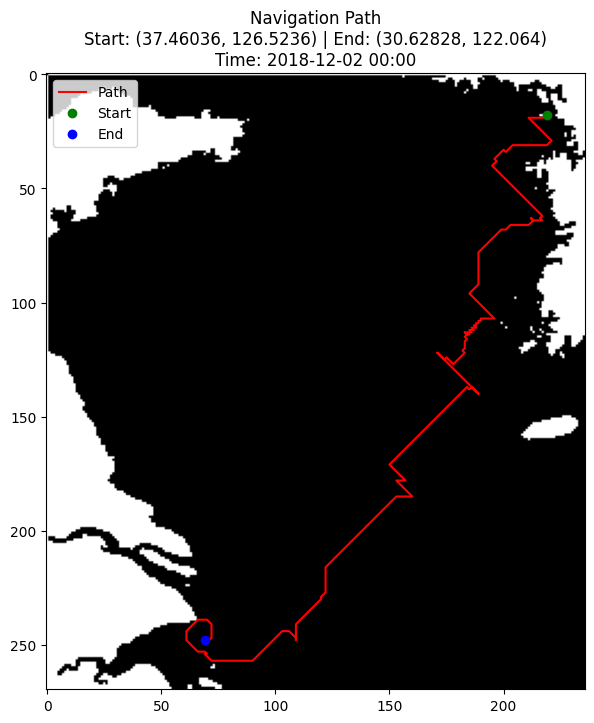

탐색 완료: 총 스텝 = 400, 총 보상 = 16.92
결과 이미지: C:\baramproject\test_results\new_sibal14\path_20181202_0000.png
디버깅 데이터: C:\baramproject\test_results\new_sibal14\debug_20181202_0000.json


In [1]:
import numpy as np
from numba import jit, float64, int64, boolean
from datetime import datetime, timedelta
import json
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# Numba로 최적화된 함수들
@jit(nopython=True)
def calculate_fuel_consumption(abs_action_angle, position, tidal_grid_dir, tidal_grid_speed, tidal_grid_valid, 
                               wind_grid_dir, wind_grid_speed, wind_grid_valid, n_rows, n_cols, f_0=1, V_s=6.68):
    row, col = position
    tidal_dir, tidal_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and tidal_grid_valid[row, col]:
        tidal_dir = tidal_grid_dir[row, col]
        tidal_speed = tidal_grid_speed[row, col]
    wind_dir, wind_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and wind_grid_valid[row, col]:
        wind_dir = wind_grid_dir[row, col]
        wind_speed = wind_grid_speed[row, col]
    
    tidal_dir_rad = (90.0 - tidal_dir) * np.pi / 180.0
    wind_dir_rad = (90.0 - wind_dir) * np.pi / 180.0
    action_angle_rad = (90.0 - abs_action_angle) * np.pi / 180.0
    
    theta_c = action_angle_rad - tidal_dir_rad
    theta_w = action_angle_rad - wind_dir_rad
    
    tidal_effect = (V_s - tidal_speed * np.cos(theta_c)) / V_s
    if tidal_effect <= 0:
        tidal_effect = 0.001
    f_tidal = f_0 * (tidal_effect ** 3)
    
    wind_effect = (V_s - wind_speed * np.cos(theta_w)) / V_s
    f_wind = f_0 * (wind_effect ** 2)
    
    total_fuel = f_tidal + f_wind
    return total_fuel

@jit(nopython=True)
def calculate_distance(end_pos, current_pos):
    rel_pos = end_pos - current_pos
    return np.linalg.norm(rel_pos)

@jit(nopython=True)
def calculate_angle(rel_pos):
    return (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)

@jit(nopython=True)
def angle_to_grid_direction(abs_action_angle, grid_angles):
    angle_diff = np.abs(grid_angles - abs_action_angle)
    closest_idx = np.argmin(angle_diff)
    return closest_idx

# 항해 환경 클래스 (수정 가능하도록 확장)
class NavigationEnv:
    def __init__(self, start_lat=37.46036, start_lon=126.52360, end_lat=30.62828, end_lon=122.06400):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(start_lat, start_lon)
        self.end_pos = self.latlon_to_grid(end_lat, end_lon)
        self.step_time_minutes = 8.5
        self.max_steps = 500
        self.cumulative_time = 0
        self.step_count = 0
        self.tidal_data_dir = r"C:\baramproject\tidal_database_interpolated"
        self.wind_data_dir = r"C:\baramproject\wind_database_interpolated"
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)
        self.current_direction = 0.0
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        self.f_0 = 1.0
        self.V_s = 6.68
        self.path = []
        self.tidal_cache = {}
        self.wind_cache = {}

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self, start_time):
        self.current_pos = self.start_pos
        self.current_direction = 0.0
        self.visit_count = {}
        self.prev_action = None
        self.previous_direction = None
        self.current_time = start_time
        self.cumulative_time = 0
        self.load_tidal_data()
        self.map_tidal_to_grid()
        self.load_wind_data()
        self.map_wind_to_grid()
        self.prev_distance = self.get_distance_to_end()
        self.initial_distance = self.get_distance_to_end()
        self.step_count = 0
        self.path = [self.current_pos]
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))
        end_angle = calculate_angle(rel_pos)
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        return calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))

    def angle_to_grid_direction(self, abs_action_angle):
        closest_idx = angle_to_grid_direction(abs_action_angle, self.grid_angles)
        return self.grid_directions[closest_idx]

    def load_tidal_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.tidal_data_dir, f"tidal_dir_{time_str}.npy")
        speed_file = os.path.join(self.tidal_data_dir, f"tidal_speed_{time_str}.npy")
        
        if time_str in self.tidal_cache:
            self.tidal_data = self.tidal_cache[time_str]
        elif os.path.exists(dir_file) and os.path.exists(speed_file):
            grid_dir = np.load(dir_file)
            grid_speed = np.load(speed_file)
            self.tidal_data = {"dir": grid_dir, "speed": grid_speed}
            self.tidal_cache[time_str] = self.tidal_data
        else:
            print(f"Warning: Tidal data files for {time_str} not found.")
            self.tidal_data = None

    def map_tidal_to_grid(self):
        if self.tidal_data is not None:
            self.tidal_grid_dir = self.tidal_data["dir"]
            self.tidal_grid_speed = self.tidal_data["speed"]
            self.tidal_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def load_wind_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.wind_data_dir, f"wind_dir_{time_str}.npy")
        speed_file = os.path.join(self.wind_data_dir, f"wind_speed_{time_str}.npy")
        
        if time_str in self.wind_cache:
            self.wind_data = self.wind_cache[time_str]
        elif os.path.exists(dir_file) and os.path.exists(speed_file):
            grid_dir = np.load(dir_file)
            grid_speed = np.load(speed_file)
            self.wind_data = {"dir": grid_dir, "speed": grid_speed}
            self.wind_cache[time_str] = self.wind_data
        else:
            print(f"Warning: Wind data files for {time_str} not found.")
            self.wind_data = None

    def map_wind_to_grid(self):
        if self.wind_data is not None:
            self.wind_grid_dir = self.wind_data["dir"]
            self.wind_grid_speed = self.wind_data["speed"]
            self.wind_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def step(self, action):
        self.step_count += 1
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        turn_penalty = 0.0
        if self.previous_direction is not None:
            angle_diff = min((abs_action_angle - self.previous_direction) % 360.0, 
                             (self.previous_direction - abs_action_angle) % 360.0)
            turn_penalty = angle_diff * 0.1
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        current_fuel = calculate_fuel_consumption(abs_action_angle, self.current_pos, self.tidal_grid_dir, 
                                                  self.tidal_grid_speed, self.tidal_grid_valid, 
                                                  self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid, 
                                                  self.n_rows, self.n_cols, self.f_0, self.V_s)
        
        moved = False
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
            moved = True
        self.previous_direction = abs_action_angle
        self.prev_action = action
        
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            next_time = self.current_time + timedelta(minutes=30)
            end_date = datetime(2018, 12, 31, 23, 30)
            if next_time <= end_date:
                self.current_time = next_time
                self.load_tidal_data()
                if self.tidal_data is None:
                    print(f"No tidal data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_tidal_to_grid()
                self.load_wind_data()
                if self.wind_data is None:
                    print(f"No wind data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_wind_to_grid()
            else:
                print("Warning: Time exceeds 2018 range. Terminating episode.")
                return self._get_state(), -1000, True, {}
            self.cumulative_time -= 30
        
        state = self._get_state()
        current_distance = self.get_distance_to_end()
        
        visit_count = self.visit_count.get(tuple(self.current_pos), 0) + 1
        self.visit_count[tuple(self.current_pos)] = visit_count
        visit_penalty = -visit_count * 0.5
        
        distance_reward = 0.0
        if self.initial_distance > 0:
            linear_reward = (1 - current_distance / self.initial_distance) * 50.0
            change_reward = (self.prev_distance - current_distance) * 10.0
            distance_reward = linear_reward + change_reward
        
        self.prev_distance = current_distance
        goal_reward = 1000.0 if current_distance <= 1.0 else 0.0
        fuel_penalty = -current_fuel * 0.05
        reward = (fuel_penalty * 0.7 + distance_reward * 1.6 - turn_penalty * 1.8 + goal_reward + visit_penalty) * 0.001
        
        if not moved:
            reward -= 2.0
        
        done = (current_distance <= 1.0) or (self.step_count >= self.max_steps)
        return state, reward, done, {}

    def _get_state(self):
        row, col = self.current_pos
        state = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                r = row + dr
                c = col + dc
                if 0 <= r < self.n_rows and 0 <= c < self.n_cols:
                    map_info = self.grid[r, c]
                    tidal_speed = self.tidal_grid_speed[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    tidal_dir = self.tidal_grid_dir[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    wind_speed = self.wind_grid_speed[r, c] if self.wind_grid_valid[r, c] else 0.0
                    wind_dir = self.wind_grid_dir[r, c] if self.wind_grid_valid[r, c] else 0.0
                    distance_to_end = calculate_distance(np.array(self.end_pos, dtype=np.float64), 
                                                        np.array([r, c], dtype=np.float64))
                else:
                    map_info = 1.0
                    tidal_speed = 0.0
                    tidal_dir = 0.0
                    wind_speed = 0.0
                    wind_dir = 0.0
                    distance_to_end = 0.0
                state.extend([map_info, tidal_speed, tidal_dir, wind_speed, wind_dir, distance_to_end])
        
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        end_angle = calculate_angle(rel_pos)
        state.append(end_angle)
        return np.array(state, dtype=np.float64)

# 테스트 함수
def test_navigation(model_path, start_time, start_lat, start_lon, end_lat, end_lon, output_dir="test_results"):
    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # 환경 초기화
    env = NavigationEnv(start_lat=start_lat, start_lon=start_lon, end_lat=end_lat, end_lon=end_lon)
    state_dim = 55
    action_dim = len(env.action_space)
    
    # 모델 로드
    policy_net = DuelingDQN(state_dim, action_dim).to(device)
    if os.path.exists(model_path):
        policy_net.load_state_dict(torch.load(model_path))
        policy_net.eval()
        print(f"모델이 {model_path}에서 성공적으로 로드되었습니다.")
    else:
        raise FileNotFoundError(f"모델 파일 {model_path}을 찾을 수 없습니다.")

    # 경로 탐색
    state = env.reset(start_time=start_time)
    done = False
    path = [env.current_pos]
    debug_data = []
    total_reward = 0
    step = 0
    
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        action = q_values.argmax().item()
        
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        debug_data.append({
            "step": step,
            "state": state.tolist(),
            "action": action,
            "reward": reward,
            "next_state": next_state.tolist(),
            "q_values": q_values.cpu().numpy().flatten().tolist(),
            "current_pos": env.current_pos,
            "time": env.current_time.strftime("%Y-%m-%d %H:%M")
        })
        
        path.append(env.current_pos)
        state = next_state
        step += 1
    
    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(env.grid, cmap='gray')
    path_array = np.array(path)
    plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
    plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
    plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
    plt.legend()
    plt.title(f"Navigation Path\nStart: ({start_lat}, {start_lon}) | End: ({end_lat}, {end_lon})\nTime: {start_time.strftime('%Y-%m-%d %H:%M')}")
    
    output_image = os.path.join(output_dir, f"path_{start_time.strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(output_image)
    plt.show()
    
    # 디버깅 데이터 저장
    output_json = os.path.join(output_dir, f"debug_{start_time.strftime('%Y%m%d_%H%M')}.json")
    with open(output_json, 'w') as f:
        json.dump(debug_data, f, indent=4)
    
    print(f"탐색 완료: 총 스텝 = {step}, 총 보상 = {total_reward:.2f}")
    print(f"결과 이미지: {output_image}")
    print(f"디버깅 데이터: {output_json}")

# 메인 실행
if __name__ == "__main__":
    # 테스트 파라미터 설정 (사용자가 수정 가능)
    model_path = r"C:\baramproject\trained_model\new_sibal14\navigation_model.pth"
    start_time = datetime(2018, 12, 2, 00, 00)  # 예: 2018년 6월 15일 12:00
    start_lat, start_lon = 37.46036, 126.52360  # 시작 위치 (위도, 경도)
    end_lat, end_lon = 30.62828, 122.06400      # 도착 위치 (위도, 경도)
    output_dir = r"C:\baramproject\test_results\new_sibal14"  # 결과 저장 디렉토리

    # 테스트 실행
    test_navigation(model_path, start_time, start_lat, start_lon, end_lat, end_lon, output_dir)